<a href="https://colab.research.google.com/github/AbdullahHemada/Vision_project/blob/main/SGD_final_UCF101_vision_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pevogam_ucf101_path = kagglehub.dataset_download('pevogam/ucf101')

print('Data source import complete.')


# Import packages

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LeakyReLU  # Import LeakyReLU
import numpy as np
from tqdm import tqdm
import pickle
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


# Import Label File

In [ ]:
label_data = pd.read_csv("/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
# label_data = label_data.drop(['index'], axis=1)
label_data.head()

,index,labels
0,1,ApplyEyeMakeup
1,2,ApplyLipstick
2,3,Archery
3,4,BabyCrawling
4,5,BalanceBeam


In [ ]:
# Total Number of video folders for classification
print(len(label_data))
print(label_data['index'],label_data['labels'])


101
0        1
1        2
2        3
3        4
4        5
      ... 
96      97
97      98
98      99
99     100
100    101
Name: index, Length: 101, dtype: int64 0         ApplyEyeMakeup
1          ApplyLipstick
2                Archery
3           BabyCrawling
4            BalanceBeam
             ...        
96     VolleyballSpiking
97        WalkingWithDog
98           WallPushups
99        WritingOnBoard
100                 YoYo
Name: labels, Length: 101, dtype: object


# Hyperparameter


In [ ]:
# # Parameters
IMG_SIZE = (96, 96)
SEQUENCE_LENGTH = 16
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 101
SAMPLES_PER_CLASS = 50   # increase samples per class to reduce overfitting

# import and read train01 and test01

In [ ]:
#read train01.txt file
UCF101_path='/kaggle/input/ucf101/UCF101/UCF-101'
train01_path='/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt'
test01_path='/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/testlist01.txt'

def load_train_list(train01_path):
    videos=[]
    labels=[]
    with open(train01_path,'r')as file:
        for line in file:
            video_path,label=line.strip().split()
            videos.append(video_path)
            labels.append(int(label)-1)

    return videos,labels

#read test01.txt file
def load_test_list(test01_path):
    videos=[]
    with open(test01_path,'r')as file:
        for line in file:
            video_path=line.strip()
            videos.append(video_path)

    return videos


# Data Preperation

# Get video fram size

In [ ]:
# get video fram size
folder = UCF101_path
for root, dirs, files in os.walk(folder):
    for file in files:
        if file.endswith(".avi"):
            video_path = os.path.join(root, file)
            cap = cv2.VideoCapture(video_path)
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            print(f"{file}: {w}x{h}")
            cap.release()

v_HorseRace_g23_c05.avi: 320x240
v_HorseRace_g18_c05.avi: 320x240
v_HorseRace_g10_c01.avi: 320x240
v_HorseRace_g18_c04.avi: 320x240
v_HorseRace_g16_c01.avi: 320x240
v_HorseRace_g04_c02.avi: 320x240
v_HorseRace_g25_c01.avi: 320x240
v_HorseRace_g05_c03.avi: 320x240
v_HorseRace_g02_c02.avi: 320x240
v_HorseRace_g12_c03.avi: 320x240
v_HorseRace_g11_c01.avi: 320x240
v_HorseRace_g07_c02.avi: 320x240
v_HorseRace_g06_c05.avi: 320x240
v_HorseRace_g05_c01.avi: 320x240
v_HorseRace_g04_c05.avi: 320x240
v_HorseRace_g20_c03.avi: 320x240
v_HorseRace_g17_c02.avi: 320x240
v_HorseRace_g01_c03.avi: 320x240
v_HorseRace_g19_c03.avi: 320x240
v_HorseRace_g09_c01.avi: 320x240
v_HorseRace_g06_c01.avi: 320x240
v_HorseRace_g16_c05.avi: 320x240
v_HorseRace_g19_c02.avi: 320x240
v_HorseRace_g24_c05.avi: 320x240
v_HorseRace_g03_c03.avi: 320x240
v_HorseRace_g03_c02.avi: 320x240
v_HorseRace_g22_c01.avi: 320x240
v_HorseRace_g14_c02.avi: 320x240
v_HorseRace_g23_c02.avi: 320x240
v_HorseRace_g21_c04.avi: 320x240
v_HorseRac

# ploting each category and its number


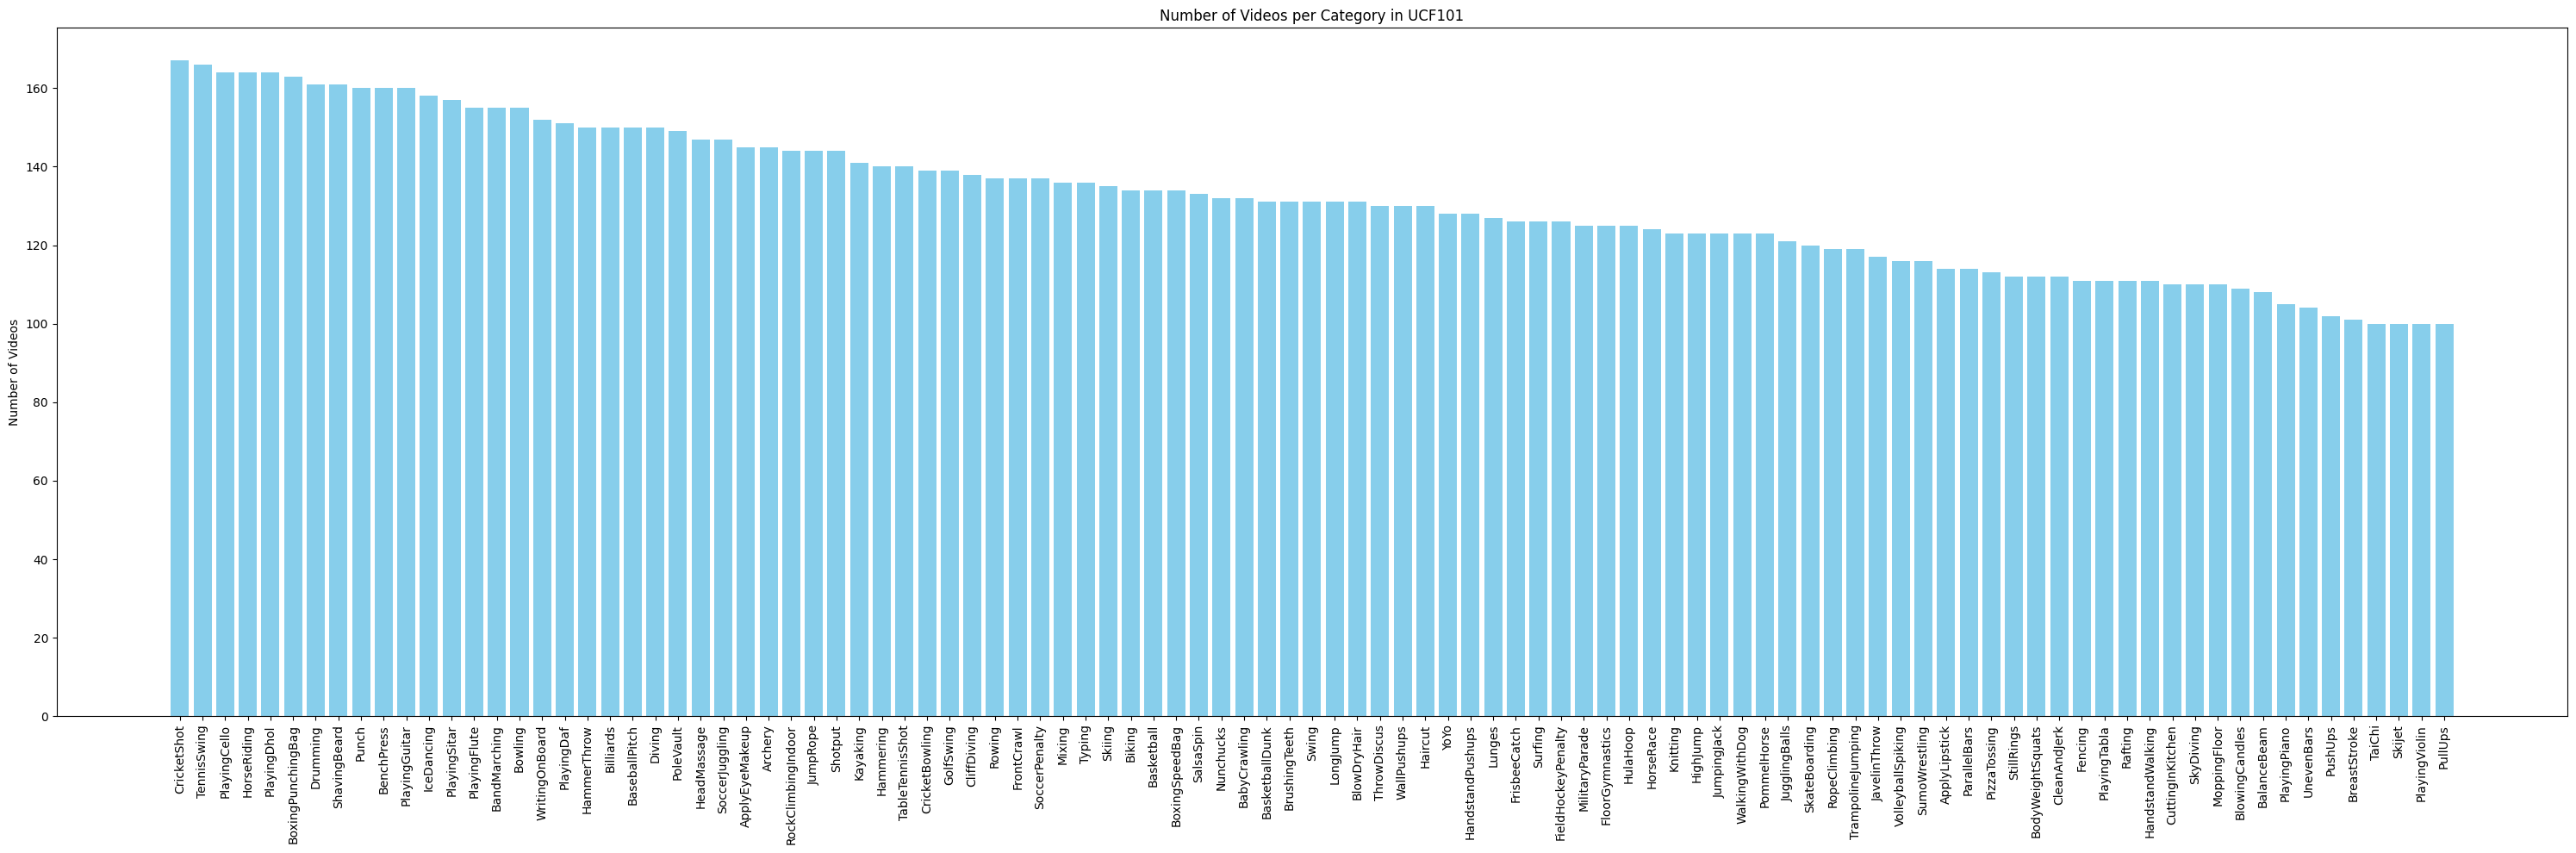

In [ ]:
# ploting each category and its number
folder = UCF101_path
categories = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

# Count videos in each category
video_counts = {}
for category in categories:
    category_path = os.path.join(folder, category)
    videos = [f for f in os.listdir(category_path) if f.endswith(".avi")]
    video_counts[category] = len(videos)

# Sort categories by number of videos (descending)
sorted_counts = dict(sorted(video_counts.items(), key=lambda item: item[1], reverse=True))

# Plot bar chart
plt.figure(figsize=(30, 10))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Number of Videos")
plt.title("Number of Videos per Category in UCF101")
plt.tight_layout()
plt.show()


# LOAD ALL FRAMES FOR TRAINING AND TESTING


In [ ]:
#load train01.txt file
train_videos, train_labels = load_train_list(train01_path)
test_videos = load_test_list(test01_path)

# label_data: DataFrame containing index and class name
class_to_index = {cls: i for i, cls in enumerate(sorted(label_data['labels']))}
print(class_to_index)


train_full_path=[]
for video in train_videos:
    train_full_path.append(os.path.join(UCF101_path, video))


test_full_path=[]
for video in test_videos:
    test_full_path.append(os.path.join(UCF101_path, video))

# print(train_full_path)
# print(test_full_path)


{'ApplyEyeMakeup': 0, 'ApplyLipstick': 1, 'Archery': 2, 'BabyCrawling': 3, 'BalanceBeam': 4, 'BandMarching': 5, 'BaseballPitch': 6, 'Basketball': 7, 'BasketballDunk': 8, 'BenchPress': 9, 'Biking': 10, 'Billiards': 11, 'BlowDryHair': 12, 'BlowingCandles': 13, 'BodyWeightSquats': 14, 'Bowling': 15, 'BoxingPunchingBag': 16, 'BoxingSpeedBag': 17, 'BreastStroke': 18, 'BrushingTeeth': 19, 'CleanAndJerk': 20, 'CliffDiving': 21, 'CricketBowling': 22, 'CricketShot': 23, 'CuttingInKitchen': 24, 'Diving': 25, 'Drumming': 26, 'Fencing': 27, 'FieldHockeyPenalty': 28, 'FloorGymnastics': 29, 'FrisbeeCatch': 30, 'FrontCrawl': 31, 'GolfSwing': 32, 'Haircut': 33, 'HammerThrow': 34, 'Hammering': 35, 'HandstandPushups': 36, 'HandstandWalking': 37, 'HeadMassage': 38, 'HighJump': 39, 'HorseRace': 40, 'HorseRiding': 41, 'HulaHoop': 42, 'IceDancing': 43, 'JavelinThrow': 44, 'JugglingBalls': 45, 'JumpRope': 46, 'JumpingJack': 47, 'Kayaking': 48, 'Knitting': 49, 'LongJump': 50, 'Lunges': 51, 'MilitaryParade': 5

# Function for Feature Extraction


In [ ]:
def feature_extraction(video_path, augment=False):
    width, height = IMG_SIZE
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count <= 0:
        return [np.zeros((height, width, 3), dtype=np.float32) for _ in range(SEQUENCE_LENGTH)]

    # random start for training only
    if frame_count > SEQUENCE_LENGTH:
        start = random.randint(0, frame_count - SEQUENCE_LENGTH)
        indices = list(range(start, start + SEQUENCE_LENGTH))
    else:
        indices = np.linspace(0, frame_count - 1, SEQUENCE_LENGTH, dtype=int)

    for idx in indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = video_reader.read()

        if not ret:
            frame = np.zeros((height, width, 3), np.float32)
        else:
            frame = cv2.resize(frame, (width, height)).astype("float32")

        # -------------------------
        # AUGMENT ONLY IF TRAINING
        # -------------------------
        if augment:
            # flip
            if random.random() < 0.5:
                frame = cv2.flip(frame, 1)

            # brightness
            if random.random() < 0.3:
                factor = 0.8 + random.random() * 0.4
                frame = np.clip(frame * factor, 0, 255)

            # jitter
            if random.random() < 0.3:
                shift = random.randint(-15, 15)
                frame = np.clip(frame + shift, 0, 255)

            # noise
            if random.random() < 0.2:
                noise = np.random.normal(0, 5, frame.shape)
                frame = np.clip(frame + noise, 0, 255)

        frames_list.append(frame)

    video_reader.release()
    return frames_list


## Load all train data in train01.txt

In [ ]:
from tqdm import tqdm
import numpy as np
import random
def load_videos(video_paths, labels=None, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE):

    X = []
    y = [] if labels is not None else None

    for i, video_path in enumerate(tqdm(video_paths, desc="Loading videos")):
        frames = feature_extraction(video_path, augment=True)
        X.append(frames)
        if labels is not None:
            y.append(labels[i])

    X = np.array(X)
    if labels is not None:
        y = np.array(y)
        return X, y
    return X

# Example usage
x_all, y_all = load_videos(train_full_path, train_labels)

# Train-validation split
x_train_manual, x_val_manual, y_train_manual, y_val_manual = train_test_split(
    x_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)


Loading videos: 100%|██████████| 9537/9537 [22:23<00:00,  7.10it/s]  


## Load all train data in test01.txt

In [ ]:


def load_test_videos(video_paths, class_to_index, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE):

    X_test = []
    y_test = []

    for video_path in tqdm(video_paths, desc="Loading test videos"):
        class_name = os.path.basename(os.path.dirname(video_path))
        label = class_to_index[class_name]
        frames = feature_extraction(video_path, augment=False)
        X_test.append(frames)
        y_test.append(label)

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_test, y_test

# Example usage
x_test, y_test = load_test_videos(test_full_path, class_to_index)



Loading test videos: 100%|██████████| 3783/3783 [07:36<00:00,  8.28it/s]


## The Proposal model: CNN + LSTM (ConvLSTM2D)

In [ ]:
# Build model
def build_model_mobilenet_lstm():
    inputs = Input(shape=(SEQUENCE_LENGTH, IMG_SIZE[0], IMG_SIZE[1], 3))

    base_cnn = MobileNetV2(
        include_top=False,
        weights="imagenet",
        pooling=None
    )
    base_cnn.trainable = False

    # Preprocess inside model
    x = TimeDistributed(Lambda(preprocess_input))(inputs)

    # Apply CNN on each frame
    x = TimeDistributed(base_cnn)(x)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    # Temporal modeling with LSTM
     # Stronger regularization (fixes test accuracy crash)
    x = LSTM(
        128,
        return_sequences=False,
        dropout=0.3,
        recurrent_dropout=0.3,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)

    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs, outputs)


# def build_model(input_shape):
#     model = Sequential()
#     model.add(BatchNormalization(momentum=0.8, input_shape=input_shape))
#     model.add(ConvLSTM2D(16, (3,3), activation=LeakyReLU(), return_sequences=True, recurrent_dropout=0.2))
#     model.add(MaxPooling3D((1,2,2), padding='same'))
#     model.add(TimeDistributed(Dropout(0.4)))

#     model.add(ConvLSTM2D(16, (3,3), activation=LeakyReLU(), return_sequences=True, recurrent_dropout=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(MaxPooling3D((1,2,2), padding='same'))
#     model.add(TimeDistributed(Dropout(0.4)))

#     model.add(Flatten())
#     model.add(BatchNormalization())
#     model.add(Dense(256, activation="relu"))   # reduced size
#     model.add(Dropout(0.5))
#     model.add(Dense(NUM_CLASSES, activation="softmax"))
#     return model





# Callbacks


In [ ]:

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [ ]:
import time

# define dictionaries BEFORE training
histories = {}
times = {}

# ➤ 2. Train with SGD

In [ ]:
model_sgd = build_model_mobilenet_lstm()

model_sgd.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(learning_rate=6e-4, momentum=0.9),
    metrics=['accuracy']
)
start = time.time()
history_sgd = model_sgd.fit(
  x_train_manual, y_train_manual,
    validation_data=(x_val_manual, y_val_manual),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],
)

end = time.time()

# Save results
histories["SGD"] = history
times["SGD"] = end - start

/tmp/ipykernel_12/7466322.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 130s 385ms/step - accuracy: 0.0178 - loss: 5.3099 - val_accuracy: 0.0456 - val_loss: 4.4975 - learning_rate: 6.0000e-04
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 78s 326ms/step - accuracy: 0.0443 - loss: 4.7211 - val_accuracy: 0.1190 - val_loss: 4.1270 - learning_rate: 6.0000e-04
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.0729 - loss: 4.3537 - val_accuracy: 0.1855 - val_loss: 3.7929 - learning_rate: 6.0000e-04
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 78s 325ms/step - accuracy: 0.1072 - loss: 4.0856 - val_accuracy: 0.2516 - val_loss: 3.5579 - learning_rate: 6.0000e-04
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 78s 326ms/step - accuracy: 0.1475 - loss: 3.8579 - val_accuracy: 0.2919 - val_loss: 3.3281 - learning_rate: 6.0000e-04
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 78s 325ms/step - accuracy: 0.1760 - loss: 3.6678 - val_accuracy: 0.3297 - val_loss: 3.1512 - learning_rate: 6.0000e-04
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 78s 3

NameError: name 'history' is not defined

In [ ]:
# Save results
histories["SGD"] = history_sgd
times["SGD"] = end - start

In [ ]:
y_pred = np.argmax(model_sgd.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_acc)

119/119 ━━━━━━━━━━━━━━━━━━━━ 51s 349ms/step
Test Accuracy: 0.39280993920169177


# Mobel train time

In [ ]:
for opt, t in times.items():
    print(f"{opt}: {t:.2f} seconds")


SGD: 3958.74 seconds


# ploting accuracy and Val_accuracy

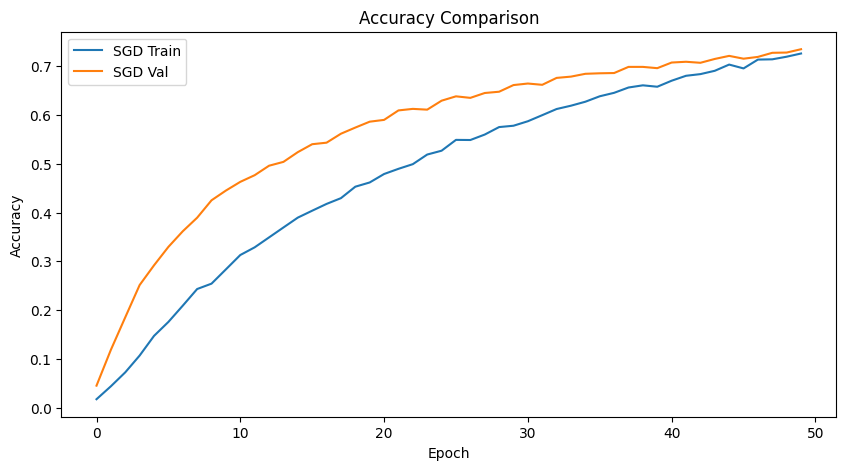

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')

plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


**Plot accuracy curves:**

# Plot loss curves:

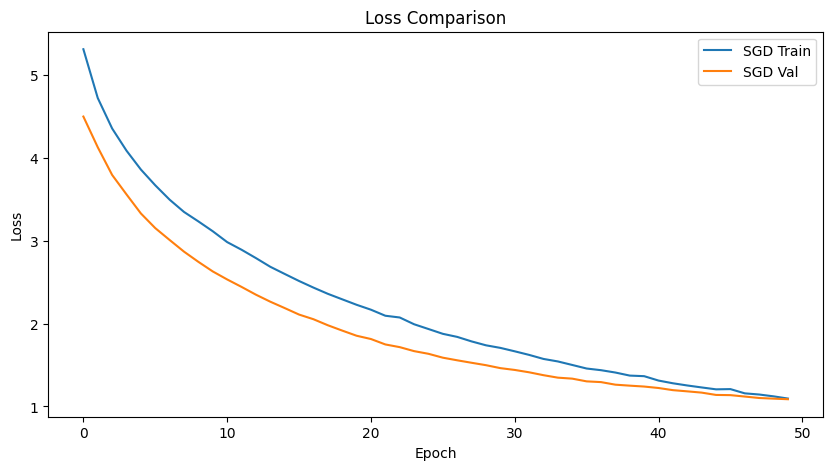

In [ ]:
plt.figure(figsize=(10,5))

for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], label=f'{name} Val')

plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# SGD Test Accuracy

In [ ]:
#Adam Test Accuracy
print("SGD Test Accuracy:", model_sgd.evaluate(x_test, y_test))


119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 252ms/step - accuracy: 0.3928 - loss: 2.7044
SGD Test Accuracy: [2.704380512237549, 0.3928099274635315]


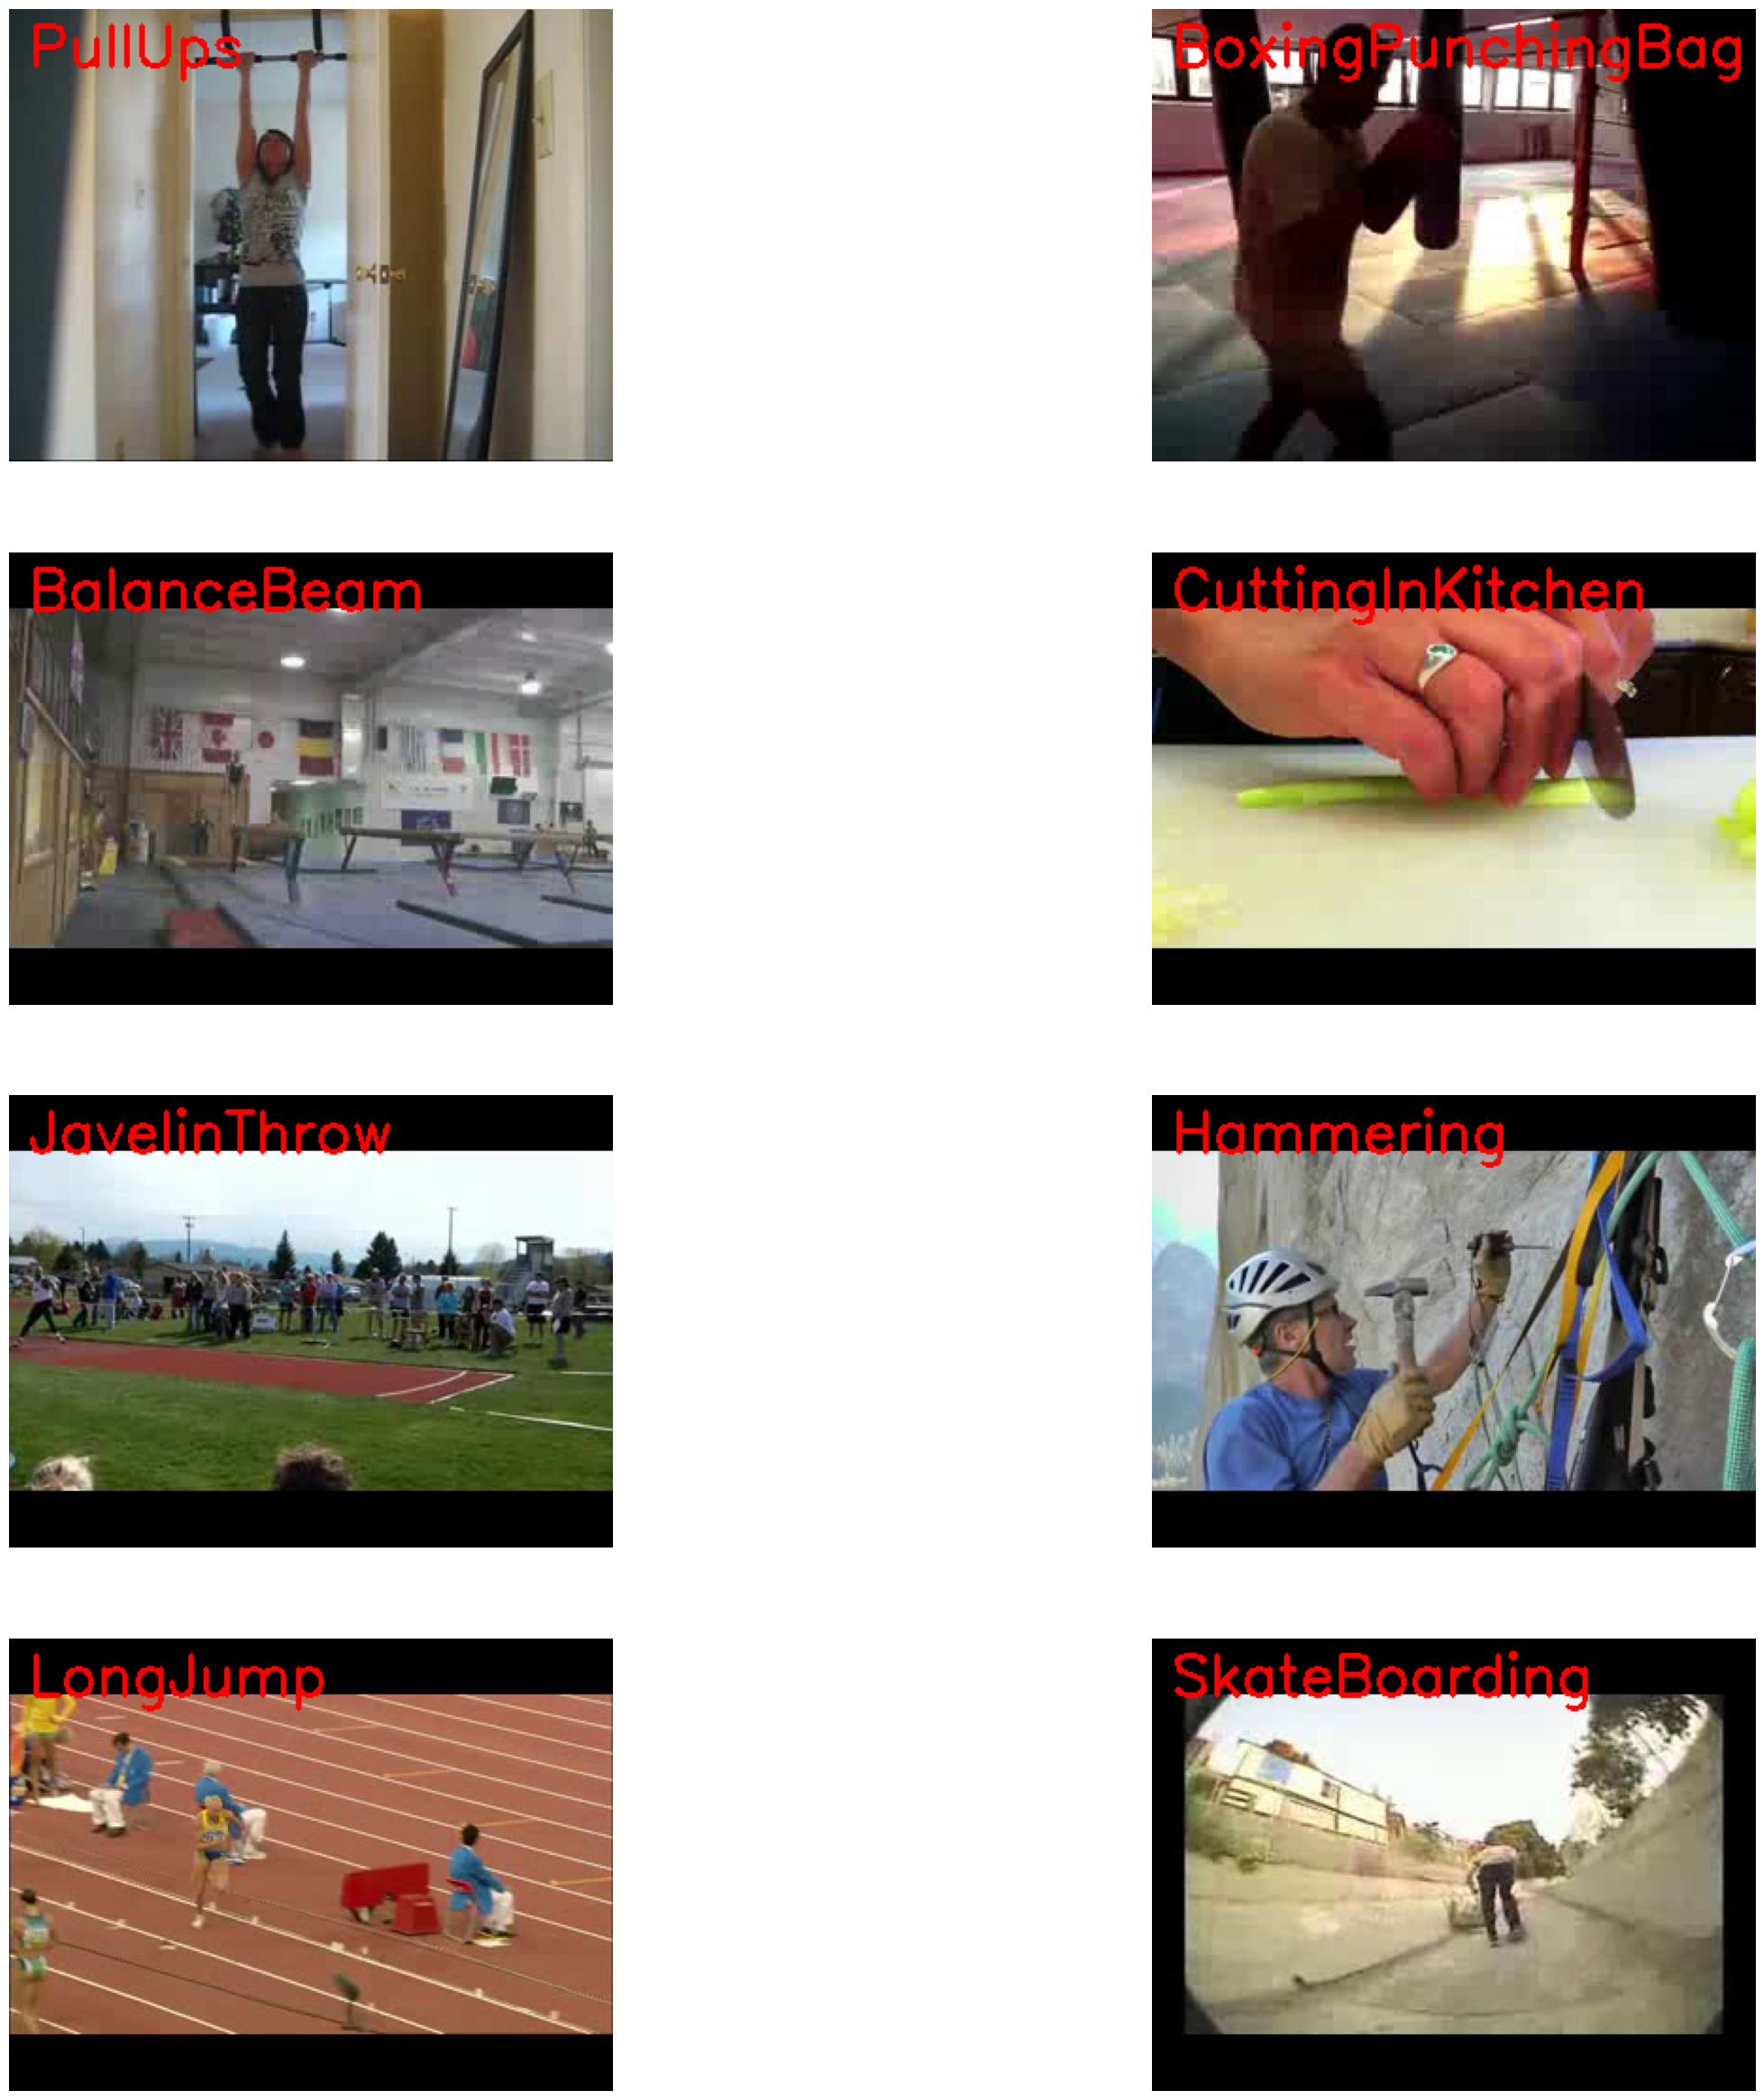

In [ ]:
import random
import os
import cv2

plt.figure(figsize=(30, 30))

all_classes_names = label_data.labels.values

random_classes = random.sample(list(all_classes_names), 8)

for i, class_name in enumerate(random_classes, 1):

    video_files = os.listdir(f'/kaggle/input/ucf101/UCF101/UCF-101/{class_name}')
    selected_video = random.choice(video_files)

    video_reader = cv2.VideoCapture(
        f'/kaggle/input/ucf101/UCF101/UCF-101/{class_name}/{selected_video}'
    )

    _, frame = video_reader.read()
    video_reader.release()

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(frame, class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

    plt.subplot(4, 2, i)
    plt.imshow(frame)
    plt.axis("off")


# confusion Matrix

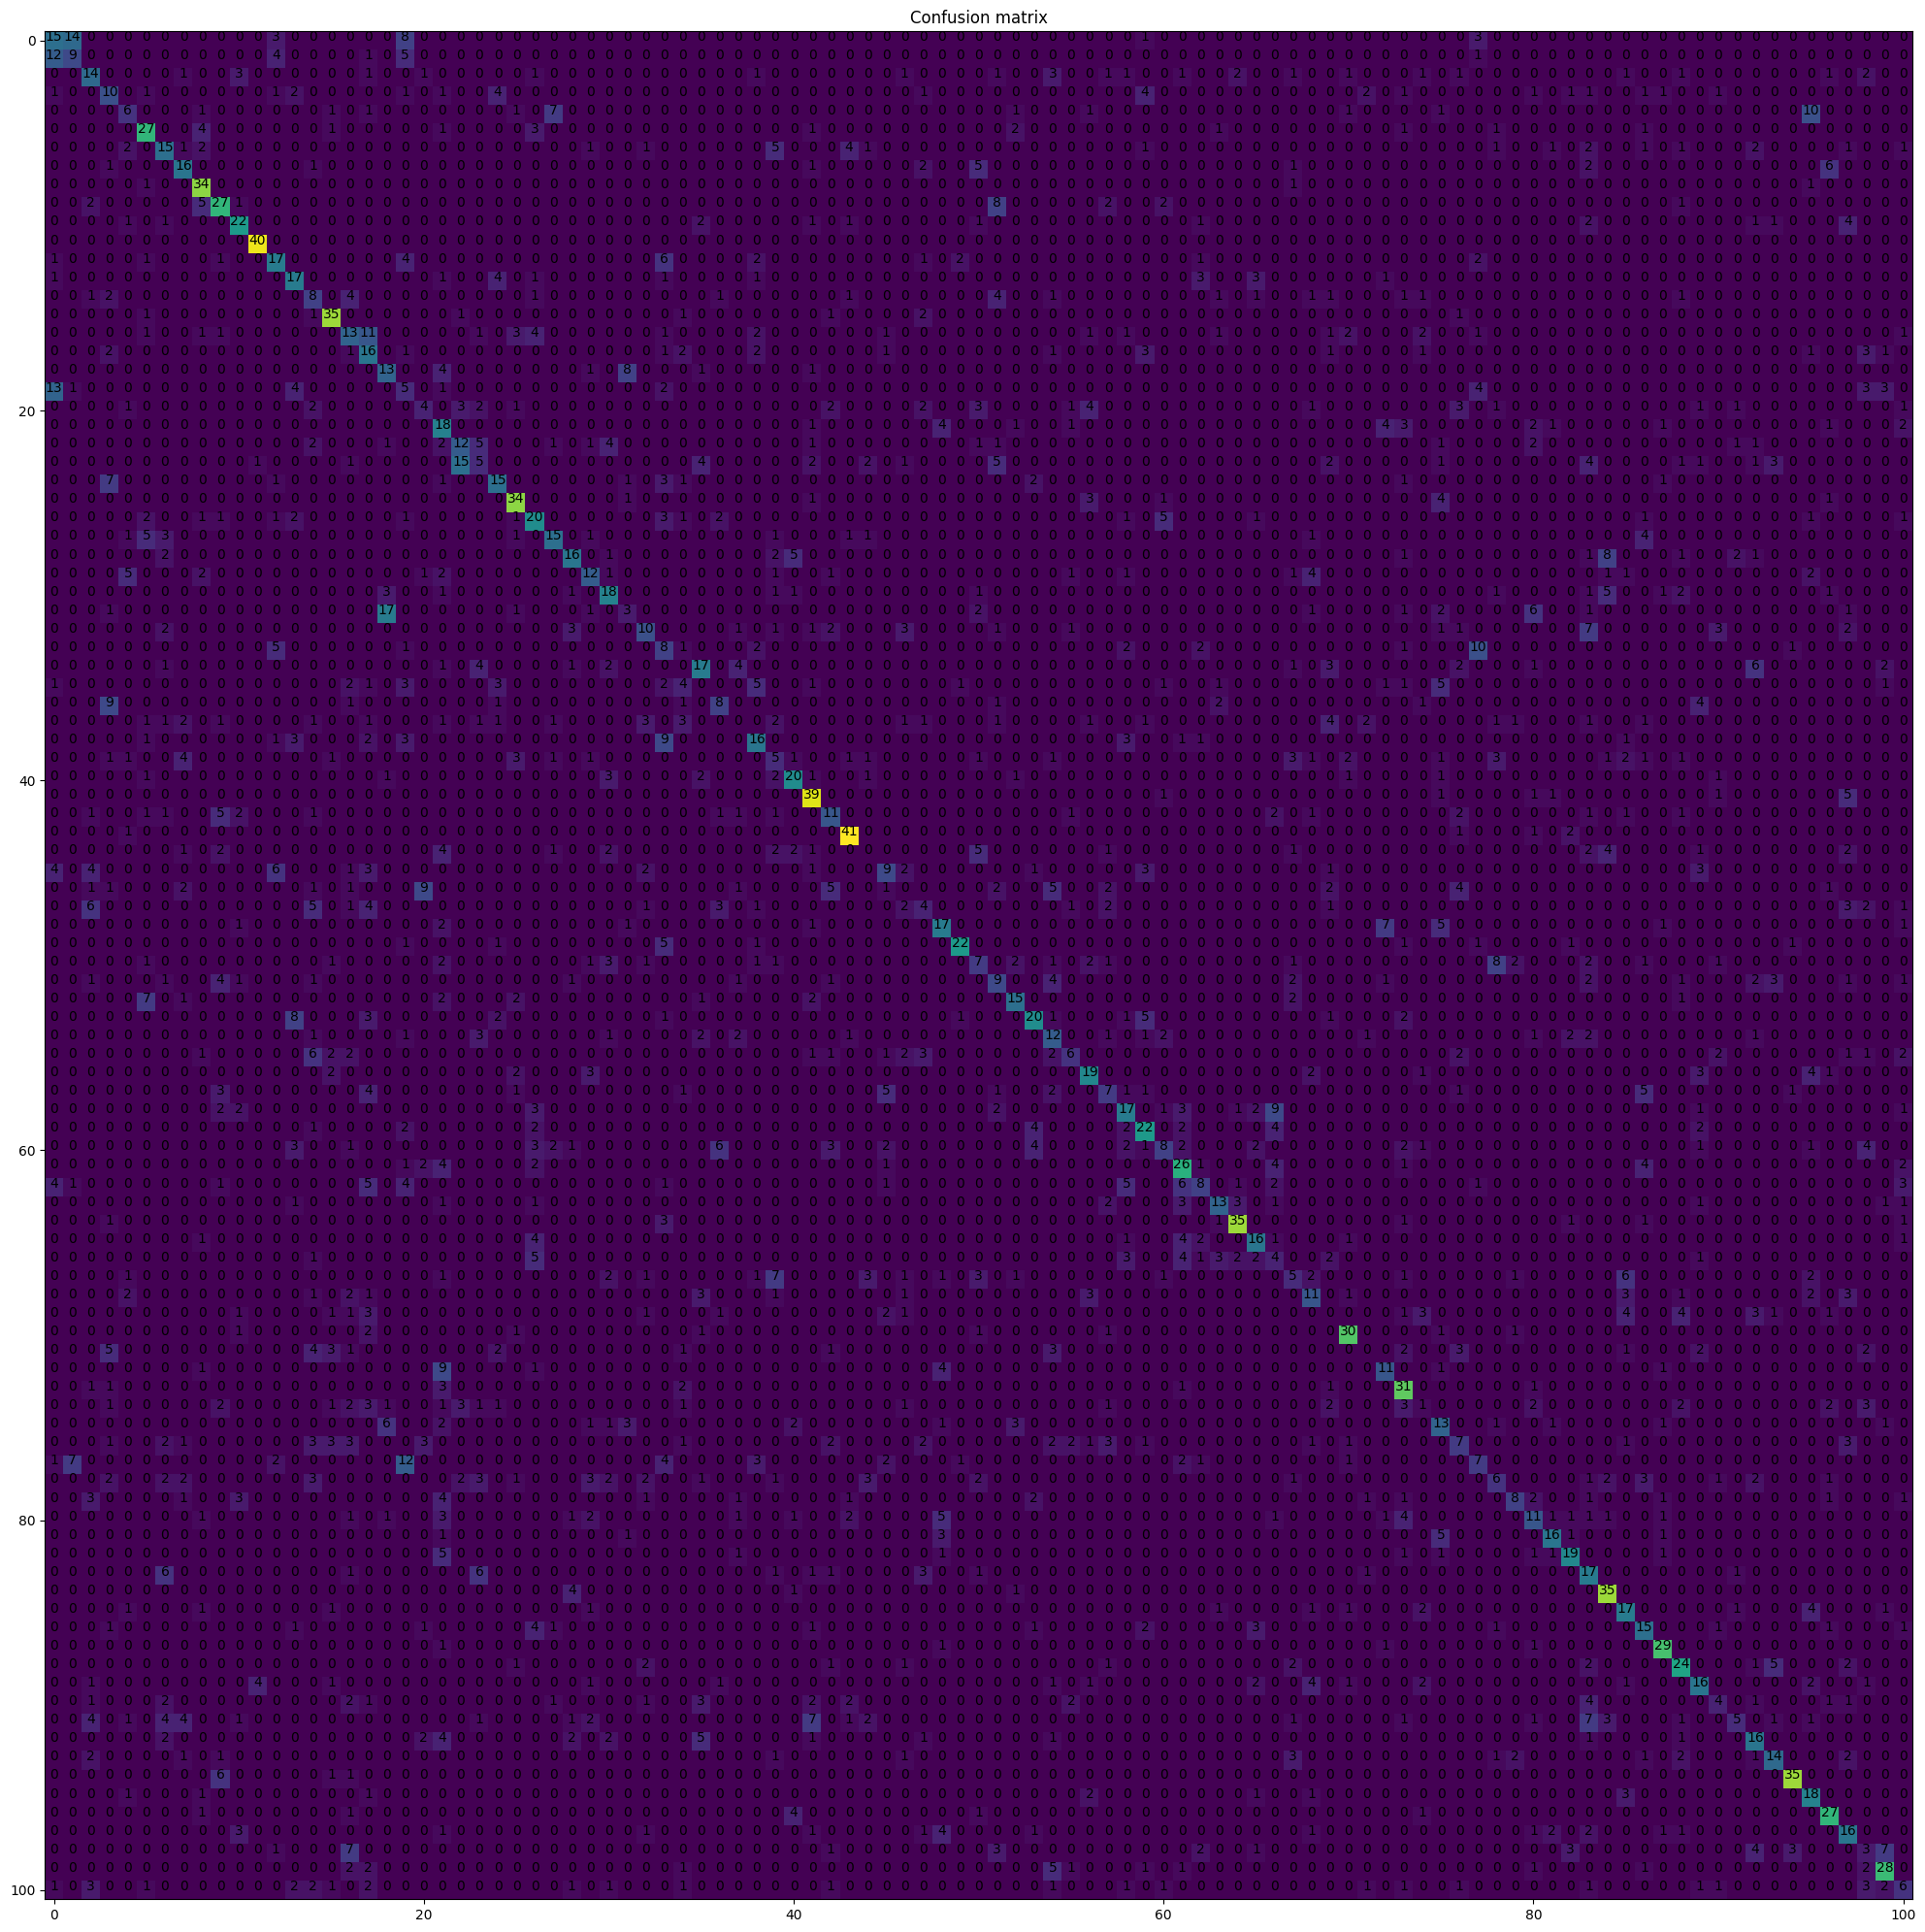

In [ ]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, y_pred)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

# save the tained model

In [ ]:
# Save the trained model Adam_optimizer
model_sgd.save('Action_Recognition_model_SGD_optimizer.keras')
print("Model saved to Action Recognition_model_SGD_optimizer.keras")


Model saved to Action Recognition_model_Adam_optimizer.keras
